In [1]:
import numpy as np
#import scipy.sparse as sp
import pandas as pd
import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
#import torch 
import copy
import dill
from sklearn.base import BaseEstimator
from lightgbm import LGBMRegressor
from multiprocessing import Pool
import matplotlib.pyplot  as plt
from sklearn.model_selection import KFold

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

***Convert to csv***

In [3]:
with open('train.txt', 'r') as f:
    data = f.read()
    data = data.replace('\t', ',')
    data = 'UserId,FilmId,Mark\n' + data
with open('train.csv', 'w') as f:
    f.write(data)

In [4]:
with open('test.txt', 'r') as f:
    data = f.read()
    data = data.replace('\t', ',')
    data = 'UserId,FilmId\n' + data
with open('test.csv', 'w') as f:
    f.write(data)

***Load Data***

In [5]:
test_raw  = pd.read_csv('test.csv')
train_raw = pd.read_csv('train.csv')

In [6]:
test_raw.head()

,UserId,FilmId
0,1,20
1,1,33
2,1,61
3,1,117
4,1,155


In [7]:
train_raw.head()

,UserId,FilmId,Mark
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3


***Write Submission***

In [8]:
def write_submission(name_of_file, prediction):
    df = pd.DataFrame()
    df['Id'] = np.arange(1, len(test_raw) + 1)
    df['Score'] = prediction
    df.to_csv(name_of_file, index=False)

***Convert to sparse matrix for ALS***

In [9]:
def convert_to_sparse(df):
    rows = []
    cols = []
    data = []
    for d in range(len(df.index)):
        cur_data = df.iloc[d]
        rows.append(cur_data['UserId'])
        cols.append(cur_data['FilmId'])
        if 'Mark' in cur_data:
            data.append(cur_data['Mark'])
        else:
            data.append(1)
    return sp.csr_matrix((data, (rows, cols)))

***ImplicitALS without bias***

In [10]:
class ImplicitALS:
    def __init__(self, lambda1=1, lambda2=1, 
                 n_epochs=35, latent_dim=3,
                 user_size=944, item_size=1683):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.user_size = user_size
        self.item_size = item_size
        self.X = np.random.randn(self.user_size, self.latent_dim)
        self.Y = np.random.randn(self.item_size, self.latent_dim)
        self.beta = np.random.randn(self.user_size)
        self.gamma = np.random.randn(self.item_size)
        self.mu = 0
        self.C = np.zeros((self.user_size, self.item_size))
        self.R = np.zeros((self.user_size, self.item_size))
        self.users = set()
        self.items = set()
        self.mses = []
    
    def describe(self):
        return 'unbiased_als ' + str([self.lambda1, self.lambda2, self.latent_dim, self.n_epochs])
    
    def fit(self, train_data, train_marks, eval_set=None, verbose=False):
        self.mu = np.mean(train_marks)
        self.R[train_data['UserId'], train_data['FilmId']] = train_marks
        self.C[train_data['UserId'], train_data['FilmId']] = 1.0
        
        self.users = set(train_data['UserId'])
        self.items = set(train_data['FilmId'])
        
        masks_i = [self.R[:, i] > 0 for i in range(self.item_size)]
        masks_u = [self.R[u, :] > 0 for u in range(self.user_size)]
        
        nonzero_i = [np.sum(self.R[:, i] > 0) for i in range(self.item_size)]
        nonzero_u = [np.sum(self.R[u, :] > 0) for u in range(self.user_size)]
        I = np.eye(self.latent_dim, self.latent_dim)
        if verbose:
            range_epochs = tqdm.tqdm(range(self.n_epochs))
        else:
            range_epochs = range(self.n_epochs)
        for j in range_epochs:
            
            #item step
            for i in range(self.item_size):
                
                if nonzero_i[i] == 0:
                    continue
                
                mask = masks_i[i]
                C_i = self.C[mask, i]
                X_i = self.X[mask]
                p_i = self.R[mask, i]
                X_iT = X_i.T
                d_i = C_i*p_i
                INV = np.linalg.inv(np.dot(X_iT*C_i, X_i) + self.lambda1*I)
                self.Y[i, :] = np.dot(INV, np.dot(X_iT, d_i))
            
            #user step            
            for u in range(self.user_size):
                
                if nonzero_u[u] == 0:
                    continue
                
                mask = masks_u[u]
                C_u = self.C[u, mask]
                Y_u = self.Y[mask]
                p_u = self.R[u, mask]
                Y_uT = Y_u.T
                d_u = C_u*p_u
                INV = np.linalg.inv(np.dot(Y_uT*C_u, Y_u) + self.lambda2*I)
                self.X[u, :] = np.dot(INV, np.dot(Y_uT, d_u))
            
            if verbose:
                clear_output(True)
                predictions = np.dot(self.X, self.Y.T)
                print(mean_squared_error(predictions[train_data['UserId'], train_data['FilmId']], train_marks))
                if not eval_set is None:
                    test_data = eval_set[0]
                    test_marks = eval_set[1]
                    prediction = predictions[test_data['UserId'], test_data['FilmId']]
                    mask_ = [not(u in self.users and i in self.items) for u, i in zip(test_data['UserId'], test_data['FilmId'])]
                    prediction[mask_] = 2.5
                    print(mean_squared_error(prediction, test_marks))
                
    def predict(self, test_data):
        predictions = np.dot(self.X, self.Y.T)
        prediction = predictions[test_data['UserId'], test_data['FilmId']]
        mask_ = [not(u in self.users and i in self.items) for u, i in zip(test_data['UserId'], test_data['FilmId'])]
        prediction[mask_] = 2.5
        return prediction

***Implicit ALS with bias***

In [11]:
class ImplicitALSBiased:
    def __init__(self, lambda1=1, lambda2=1, 
                 n_epochs=35, latent_dim=3,
                 user_size=944, item_size=1683):
        self.lambda1 = lambda1
        self.lambda2 = lambda2
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.user_size = user_size
        self.item_size = item_size
        self.X = np.random.randn(self.user_size, self.latent_dim + 2)
        self.Y = np.random.randn(self.item_size, self.latent_dim + 2)
        ####################
        self.X[:, 0] = 1.0
        self.Y[:, -1] = 1.0
        ####################        
        self.beta = 0.1*np.random.randn(self.user_size)
        self.gamma = 0.1*np.random.randn(self.item_size)
        self.mu = 0
        self.C = np.zeros((self.user_size, self.item_size))
        self.R = np.zeros((self.user_size, self.item_size))
        self.users = set()
        self.items = set()
        self.mses = []
    
    def describe(self):
        return 'biased_als ' + str([self.lambda1, self.lambda2, self.latent_dim, self.latent_dim])
    
    def fit(self, train_data, train_marks, eval_set=None, C=None, verbose=False):
        
        self.mu = np.mean(train_marks)
        
        self.R[train_data['UserId'], train_data['FilmId']] = train_marks
        if C is None:
            self.C[train_data['UserId'], train_data['FilmId']] = 1.0
        else:
            self.C[train_data['UserId'], train_data['FilmId']] = C
        
        self.users = set(train_data['UserId'])
        self.items = set(train_data['FilmId'])
        
        masks_i = [self.R[:, i] > 0 for i in range(self.item_size)]
        masks_u = [self.R[u, :] > 0 for u in range(self.user_size)]
        
        nonzero_i = [np.sum(self.R[:, i] > 0) for i in range(self.item_size)]
        nonzero_u = [np.sum(self.R[u, :] > 0) for u in range(self.user_size)]
        
        I = np.eye(self.latent_dim + 1, self.latent_dim + 1)
        
        if verbose:
            range_epochs = tqdm.tqdm(range(self.n_epochs))
        else:
            range_epochs = range(self.n_epochs)
            
        
        for j in range_epochs:
            
            #item step
            for i in range(self.item_size):
                
                if nonzero_i[i] == 0:
                    continue
                
                mask = masks_i[i]
                C_i = self.C[mask, i]
                X_i = self.X[mask, :-1]
                p_i = self.R[mask, i] - self.X[mask, -1] - self.mu
                X_iT = X_i.T
                d_i = C_i*p_i
                INV = np.linalg.inv(np.dot(X_iT*C_i, X_i) + self.lambda1*I)
                self.Y[i, :-1] = np.dot(INV, np.dot(X_iT, d_i))
            
            #user step            
            for u in range(self.user_size):
                
                if nonzero_u[u] == 0:
                    continue
                
                mask = masks_u[u]
                C_u = self.C[u, mask]
                Y_u = self.Y[mask, 1:]
                p_u = self.R[u, mask] - self.Y[mask, 0] - self.mu
                Y_uT = Y_u.T
                d_u = C_u*p_u
                INV = np.linalg.inv(np.dot(Y_uT*C_u, Y_u) + self.lambda2*I)
                self.X[u, 1:] = np.dot(INV, np.dot(Y_uT, d_u))
            
            if verbose:
                clear_output(True)
                predictions = np.dot(self.X, self.Y.T)
                print(mean_squared_error(self.mu + predictions[train_data['UserId'], train_data['FilmId']], train_marks))
                if not eval_set is None:
                    test_data = eval_set[0]
                    test_marks = eval_set[1]
                    prediction = self.mu + predictions[test_data['UserId'], test_data['FilmId']]
                    mask_ = [not(u in self.users and i in self.items) for u, i in zip(test_data['UserId'], test_data['FilmId'])]
                    prediction[mask_] = self.mu
                    mask_ = [u not in self.users and i in self.items for u, i in zip(test_data['UserId'], test_data['FilmId'])]
                    prediction[mask_] = self.mu + self.Y[test_data['FilmId'][mask_], 0]
                    mask_ = [u in self.users and i not in self.items for u, i in zip(test_data['UserId'], test_data['FilmId'])]
                    prediction[mask_] = self.mu + self.X[test_data['UserId'][mask_], -1]
                    print(mean_squared_error(prediction, test_marks))
                
    def predict(self, test_data):
        predictions = np.dot(self.X, self.Y.T)
        prediction = self.mu + predictions[test_data['UserId'], test_data['FilmId']]
        mask_ = [not(u in self.users and i in self.items) for u, i in zip(test_data['UserId'], test_data['FilmId'])]
        prediction[mask_] = self.mu
        mask_ = [u not in self.users and i in self.items for u, i in zip(test_data['UserId'], test_data['FilmId'])]
        prediction[mask_] = self.mu + self.Y[test_data['FilmId'][mask_], 0]
        mask_ = [u in self.users and i not in self.items for u, i in zip(test_data['UserId'], test_data['FilmId'])]
        prediction[mask_] = self.mu + self.X[test_data['UserId'][mask_], -1]
        return prediction
    
    def predict_semisupervise(self, test_data):
        predictions = np.dot(self.X, self.Y.T)
        prediction = self.mu + predictions[test_data['UserId'], test_data['FilmId']]
        mask_ = [not(u in self.users or i in self.items) for u, i in zip(test_data['UserId'], test_data['FilmId'])]
        return prediction, mask_

In [12]:
def func(i):
    if i < 10:
        return 0.95
    elif i < 25:
        return 0.9
    elif i < 40:
        return 0.75
    elif i < 100:
        return 0.5
    else:
        return 0.2

In [13]:
class SemiSuperviseIALS:
    def __init__(self, ss_ials):
        self.models = copy.deepcopy(ss_ials)
        self.implicit_models = None
        self.explicit_models = None
    
    def describe(self):
        return 'ss_ials ' + self.models[0].describe()
    
    def fit(self, n_added, train_data, train_marks, test_data, verbose=False):
        explicit_models = copy.deepcopy(self.models)
        predictions = []
        C = np.ones(train_marks.shape[0])
        if verbose:
            range_models = tqdm.tqdm(range(len(explicit_models)))
        else:
            range_models = range(len(explicit_models))
        for i in range_models:
            new_index = np.random.permutation(train_marks.shape[0])[:-1000]
            explicit_models[i].fit(train_data.iloc[new_index], train_marks.iloc[new_index])
            cur_pred, cur_mask = explicit_models[i].predict_semisupervise(test_data)
            predictions.append(cur_pred)
        self.explicit_models = explicit_models
        predictions = np.array(predictions) 
        predictions_vars = np.var(predictions, axis=0)
        predictions_old = np.array(predictions)
        predictions = np.mean(predictions, axis=0)
        args = np.argsort(predictions_vars)[:n_added]
        candidates = test_data.iloc[args]
        candidates_marks = pd.DataFrame(predictions[args])
        new_train_marks = pd.concat((train_marks, candidates_marks), axis=0).squeeze(1)
        new_train_data = pd.concat((train_data, candidates), axis=0)
        C = np.concatenate((C, np.array([func(i) for i in range(n_added)])))
        self.implicit_models = copy.deepcopy(self.models)
        predictions = []
        if verbose:
            range_models = tqdm.tqdm(range(len(explicit_models)))
        else:
            range_models = range(len(explicit_models))
        for i in range_models:
            self.implicit_models[i].fit(new_train_data, new_train_marks, C=C)
            #cur_pred = self.implicit_models[i].predict(test_data)
            #predictions.append(cur_pred)
        #predictions = np.array(predictions)
        #predictions = np.mean(predictions, axis=0)
        #return predictions, predictions_old
    
    def predict(self, test_data):
        predictions = []
        for i in range(len(self.implicit_models)):
            predictions.append(self.implicit_models[i].predict(test_data))
            predictions.append(self.explicit_models[i].predict(test_data))
        predictions = np.array(predictions)
        return np.mean(predictions, axis=0)

In [14]:
def train_model(data):
    model = copy.deepcopy(data[0])
    train_raw = data[1]
    test_raw = data[2]
    model.fit(train_raw[['UserId', 'FilmId']], train_raw['Mark'])
    prediction = model.predict(test_raw)
    return {'model':model.describe(), 'test_prediction':prediction} 

In [15]:
def stack_model(data):
    model = data[0]
    train_raw = data[1]
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    prediction = np.zeros(train_raw.shape[0])
    for train_index, test_index in kf.split(train_raw):
        train_kf, test_kf = train_raw.iloc[train_index], train_raw.iloc[test_index]
        model_kf = copy.deepcopy(model)
        model_kf.fit(train_kf[['UserId', 'FilmId']], train_kf['Mark'])
        cur_pred = model_kf.predict(test_kf[['UserId', 'FilmId']])
        prediction[test_index] = cur_pred
    return {'model':model.describe(), 'prediction':prediction}   

In [16]:
def stack_implicit_model(data):
    model = copy.deepcopy(data[0])
    train_raw = data[1]
    kf = KFold(n_splits=4, shuffle=True, random_state=42)
    prediction = np.zeros(train_raw.shape[0])
    for train_index, test_index in kf.split(train_raw):
        train_kf, test_kf = train_raw.iloc[train_index], train_raw.iloc[test_index]
        model_kf = copy.deepcopy(model)
        model_kf.fit(500, train_kf[['UserId', 'FilmId']], train_kf['Mark'], test_kf)
        prediction[test_index] = model_kf.predict(test_kf)
    return {'model':model.describe(), 'prediction':prediction}

In [17]:
def train_implicit_model(data):
    model = copy.deepcopy(data[0])
    train_raw = data[1]
    test_raw = data[2]
    model.fit(500, train_raw[['UserId', 'FilmId']], train_raw['Mark'], test_raw)
    prediction = model.predict(test_raw)
    return {'model': model.describe(), 'test_prediction':prediction}

***Explicit ALS stacking***

In [18]:
models = [ImplicitALS(latent_dim=4, lambda1=7, lambda2=7, n_epochs=40),
         ImplicitALS(latent_dim=4, lambda1=10, lambda2=10, n_epochs=40),
         ImplicitALS(latent_dim=4, lambda1=12, lambda2=12, n_epochs=40),
         ImplicitALS(latent_dim=5, lambda1=5, lambda2=5, n_epochs=40),
         ImplicitALS(latent_dim=5, lambda1=7, lambda2=7, n_epochs=40),
         ImplicitALS(latent_dim=5, lambda1=10, lambda2=10, n_epochs=40),
         ImplicitALS(latent_dim=5, lambda1=12, lambda2=12, n_epochs=40),
         ImplicitALS(latent_dim=6, lambda1=5, lambda2=5, n_epochs=40),
         ImplicitALS(latent_dim=6, lambda1=7, lambda2=7, n_epochs=40),
         ImplicitALS(latent_dim=6, lambda1=10, lambda2=10, n_epochs=40),####
         ImplicitALSBiased(latent_dim=4, lambda1=5, lambda2=5, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=7, lambda2=7, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=10, lambda2=10, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=12, lambda2=12, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=5, lambda2=5, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=7, lambda2=7, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=10, lambda2=10, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=12, lambda2=12, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=5, lambda2=5, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=7, lambda2=7, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=10, lambda2=10, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=12, lambda2=12, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=15, lambda2=15, n_epochs=40),
         ImplicitALSBiased(latent_dim=8, lambda1=12, lambda2=12, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=5, lambda2=5, n_epochs=65),
         ImplicitALSBiased(latent_dim=4, lambda1=7, lambda2=7, n_epochs=65),
         ImplicitALSBiased(latent_dim=4, lambda1=10, lambda2=10, n_epochs=65),
         ImplicitALSBiased(latent_dim=4, lambda1=12, lambda2=12, n_epochs=65),
         ImplicitALSBiased(latent_dim=5, lambda1=5, lambda2=5, n_epochs=65),
         ImplicitALSBiased(latent_dim=5, lambda1=7, lambda2=7, n_epochs=65),
         ImplicitALSBiased(latent_dim=5, lambda1=10, lambda2=10, n_epochs=65),
         ImplicitALSBiased(latent_dim=5, lambda1=12, lambda2=12, n_epochs=65),
         ImplicitALSBiased(latent_dim=6, lambda1=5, lambda2=5, n_epochs=65),
         ImplicitALSBiased(latent_dim=6, lambda1=7, lambda2=7, n_epochs=65),
         ImplicitALSBiased(latent_dim=6, lambda1=10, lambda2=10, n_epochs=65),
         ImplicitALSBiased(latent_dim=6, lambda1=12, lambda2=12, n_epochs=65),
         ImplicitALSBiased(latent_dim=6, lambda1=15, lambda2=15, n_epochs=65),
         ImplicitALSBiased(latent_dim=8, lambda1=12, lambda2=12, n_epochs=65),
         ImplicitALSBiased(latent_dim=4, lambda1=5, lambda2=5, n_epochs=25),
         ImplicitALSBiased(latent_dim=4, lambda1=7, lambda2=7, n_epochs=25),
         ImplicitALSBiased(latent_dim=4, lambda1=10, lambda2=10, n_epochs=25),
         ImplicitALSBiased(latent_dim=4, lambda1=12, lambda2=12, n_epochs=25),
         ImplicitALSBiased(latent_dim=5, lambda1=5, lambda2=5, n_epochs=25),
         ImplicitALSBiased(latent_dim=5, lambda1=7, lambda2=7, n_epochs=25),
         ImplicitALSBiased(latent_dim=5, lambda1=10, lambda2=10, n_epochs=25),
         ImplicitALSBiased(latent_dim=5, lambda1=12, lambda2=12, n_epochs=25),
         ImplicitALSBiased(latent_dim=6, lambda1=5, lambda2=5, n_epochs=25),
         ImplicitALSBiased(latent_dim=6, lambda1=7, lambda2=7, n_epochs=25),
         ImplicitALSBiased(latent_dim=6, lambda1=10, lambda2=10, n_epochs=25),
         ImplicitALSBiased(latent_dim=6, lambda1=12, lambda2=12, n_epochs=25),
         ImplicitALSBiased(latent_dim=6, lambda1=15, lambda2=15, n_epochs=25),
         ImplicitALSBiased(latent_dim=8, lambda1=12, lambda2=12, n_epochs=25),
         ImplicitALSBiased(latent_dim=4, lambda1=3, lambda2=5, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=5, lambda2=3, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=6, lambda2=10, n_epochs=40),
         ImplicitALSBiased(latent_dim=4, lambda1=10, lambda2=6, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=12, lambda2=7, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=7, lambda2=12, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=14, lambda2=7, n_epochs=40),
         ImplicitALSBiased(latent_dim=5, lambda1=7, lambda2=14, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=7, lambda2=5, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=5, lambda2=7, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=3, lambda2=10, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=10, lambda2=3, n_epochs=40),
         ImplicitALSBiased(latent_dim=6, lambda1=15, lambda2=9, n_epochs=40),
         ImplicitALSBiased(latent_dim=8, lambda1=9, lambda2=15, n_epochs=40)]
additional_params = dill.load(open('params.dill', 'rb'))
additional_models = [ImplicitALSBiased(latent_dim=p[2], lambda1=p[0], lambda2=p[1], n_epochs=p[3]) for p in additional_params]
models.extend(additional_models)

In [19]:
data = [(model, copy.deepcopy(train_raw)) for model in models]
data_train = [(model, copy.deepcopy(train_raw), copy.deepcopy(test_raw)) for model in models]
dill.dump(models, open('explicit_models.dill', 'wb'))

In [20]:
stacking_explicit = []
for d in tqdm.tqdm(data):
    stacking_explicit.append(stack_model(d))

100%|██████████| 107/107 [41:17<00:00, 23.15s/it]


In [21]:
dill.dump(stacking_explicit, open('stacking_explicit.dill', 'wb'))

In [22]:
test_explicit = []
for d in tqdm.tqdm(data_train):
    test_explicit.append(train_model(d))

100%|██████████| 107/107 [09:08<00:00,  5.13s/it]


In [23]:
dill.dump(test_explicit, open('test_explicit.dill', 'wb'))

***Implicit ALS stacking***

In [24]:
sialses = [SemiSuperviseIALS([ImplicitALSBiased(latent_dim=3, lambda1=4, lambda2=4, n_epochs=45) for i in range(10)]),
           SemiSuperviseIALS([ImplicitALSBiased(latent_dim=4, lambda1=4, lambda2=4, n_epochs=45) for i in range(10)]),
           SemiSuperviseIALS([ImplicitALSBiased(latent_dim=4, lambda1=5, lambda2=5, n_epochs=45) for i in range(10)]),
           SemiSuperviseIALS([ImplicitALSBiased(latent_dim=2, lambda1=4, lambda2=4, n_epochs=40) for i in range(10)]),
           SemiSuperviseIALS([ImplicitALSBiased(latent_dim=5, lambda1=7, lambda2=7, n_epochs=40) for i in range(10)])]

In [25]:
data_implicit = [(model, copy.deepcopy(train_raw)) for model in sialses]
data_implicit_test = [(model, copy.deepcopy(train_raw), copy.deepcopy(test_raw)) for model in sialses]
dill.dump(sialses, open('sialses.dill', 'wb'))

In [26]:
stacking_implicit = []
for d in tqdm.tqdm(data_implicit):
    stacking_implicit.append(stack_implicit_model(d))

100%|██████████| 5/5 [32:46<00:00, 393.38s/it]


In [27]:
dill.dump(stacking_implicit, open('stacking_implicit.dill', 'wb'))

In [28]:
test_implicit = []
for d in tqdm.tqdm(data_implicit_test):
    test_implicit.append(train_implicit_model(d))

100%|██████████| 5/5 [08:33<00:00, 102.61s/it]


In [29]:
dill.dump(test_implicit, open('test_implicit.dill', 'wb'))

***Dataset for boosting***

In [30]:
stacking_explicit = dill.load(open('stacking_explicit.dill', 'rb'))
stacking_implicit = dill.load(open('stacking_implicit.dill', 'rb'))

In [31]:
model_names = []
predictions = []
for i in stacking_explicit:
    model_names.append(i['model'])
    predictions.append(i['prediction'])
for i in stacking_implicit:
    model_names.append(i['model'])
    predictions.append(i['prediction'])

In [32]:
train_stacked = pd.DataFrame(predictions, index = model_names).T

In [33]:
test_explicit = dill.load(open('test_explicit.dill', 'rb'))
test_implicit = dill.load(open('test_implicit.dill', 'rb'))

In [34]:
model_names = []
predictions = []
for i in test_explicit:
    model_names.append(i['model'])
    predictions.append(i['test_prediction'])
for i in test_implicit:
    model_names.append(i['model'])
    predictions.append(i['test_prediction'])

In [35]:
test_stacked = pd.DataFrame(predictions, index = model_names).T

In [36]:
test_stacked.head()

,"unbiased_als [7, 7, 4, 40]","unbiased_als [10, 10, 4, 40]","unbiased_als [12, 12, 4, 40]","unbiased_als [5, 5, 5, 40]","unbiased_als [7, 7, 5, 40]","unbiased_als [10, 10, 5, 40]","unbiased_als [12, 12, 5, 40]","unbiased_als [5, 5, 6, 40]","unbiased_als [7, 7, 6, 40]","unbiased_als [10, 10, 6, 40]",...,"biased_als [8, 8, 3, 3]","biased_als [5, 5, 4, 4]","biased_als [6, 6, 3, 3]","biased_als [10, 10, 4, 4]","biased_als [8, 8, 4, 4]","ss_ials biased_als [4, 4, 3, 3]","ss_ials biased_als [4, 4, 4, 4]","ss_ials biased_als [5, 5, 4, 4]","ss_ials biased_als [4, 4, 2, 2]","ss_ials biased_als [7, 7, 5, 5]"
0,3.592601,3.733556,3.696535,3.532348,3.524818,3.482530,3.491156,3.534645,3.923361,3.909867,...,3.288667,3.522192,3.353738,3.714608,3.701243,3.336324,3.467200,3.649741,3.841463,3.795175
1,3.550760,3.509360,3.487067,3.521843,3.473323,3.392697,3.396442,3.519983,3.279215,3.286031,...,3.470855,3.281536,3.449982,3.391374,3.388822,3.442233,3.292226,3.300970,3.492179,3.306232
2,4.054709,4.064456,4.011243,4.147824,4.066299,3.962364,3.932126,4.117941,4.062959,4.031632,...,3.830440,3.806959,3.849735,3.903995,3.892564,3.857864,3.790467,3.829250,4.021208,3.859430
3,3.378575,3.349753,3.378884,3.397274,3.476615,3.327078,3.353676,3.401224,3.610752,3.567498,...,3.400994,3.308071,3.316595,3.499542,3.579876,3.308004,3.388554,3.407134,3.196367,3.625017
4,2.406212,2.522759,2.532276,2.426052,2.392385,2.282347,2.322190,2.372856,2.003895,2.015269,...,2.338748,2.122675,2.333513,2.149856,2.112699,2.284969,2.175137,2.070347,2.441314,2.075735


***Boosting***

In [37]:
y_train = train_raw['Mark']
X_train = train_stacked.values
X_test = test_stacked.values

Min MSE -  0.8037962968773544 Min iter -  150 Cur MSE -  0.8038601486458635


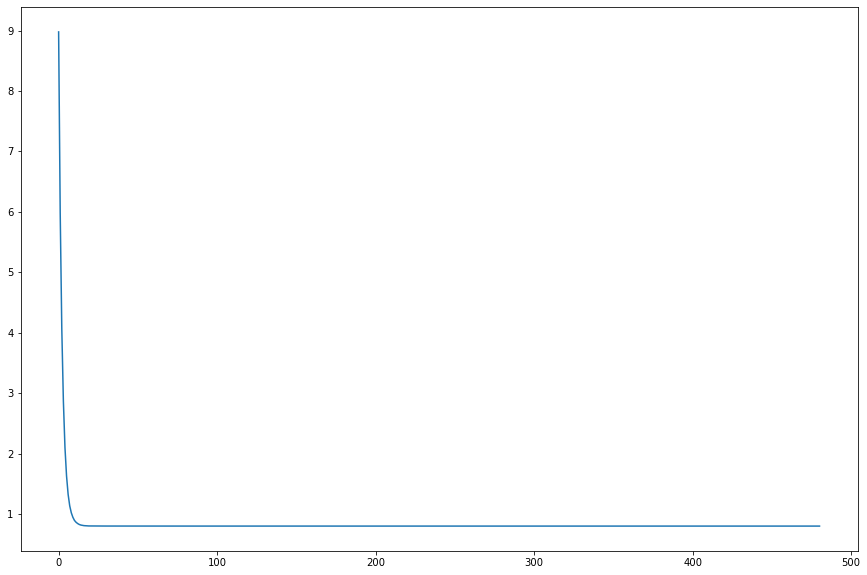

100%|██████████| 500/500 [44:01<00:00,  5.28s/it]


In [38]:
bagging = []
prediction = np.zeros_like(y_train).astype(float)
s1 = set(np.arange(0, y_train.shape[0]))
norms = np.zeros_like(prediction).astype(float) + 1e-100
mses = []
estimators = []
for i in tqdm.tqdm(range(500)):
    index_bagg = np.random.randint(low=0, high=y_train.shape[0], size=y_train.shape[0])
    #print(y_train.shape[0])
    #print(X_train.shape[0])
    X_bagg = X_train[index_bagg]
    y_bagg = y_train[index_bagg]
    #print(X_bagg.shape[0])
    
    lgbm = LGBMRegressor(n_estimators=400, learning_rate=0.05, max_depth=4, num_leaves=100)
    #lgbm = CatBoostRegressor(n_estimators=200, learning_rate=0.05, max_depth=4, verbose=False, task_type='GPU')
    lgbm.fit(X_bagg, y_bagg)
    s2 = set(index_bagg)
    out_of_bag = list(s1 - s2)
    X_oub = X_train[out_of_bag]
    prediction[out_of_bag] += lgbm.predict(X_oub)
    norms[out_of_bag] += 1.0
    mses.append(mean_squared_error(prediction/norms, y_train))
    estimators.append(lgbm)
    if i % 20 == 0 and i != 0:
        clear_output(True)
        plt.figure(figsize=(15, 10))
        plt.plot(mses)
        print('Min MSE - ', np.min(mses), 'Min iter - ', np.argmin(mses), 'Cur MSE - ', mses[-1])
        plt.show()

In [39]:
prediction = np.zeros(len(test_stacked.index))
for estim in estimators:
    prediction += estim.predict(test_stacked.values)
prediction /= len(estimators)

In [40]:
test_prediction = pd.DataFrame()
test_prediction['Id'] = np.arange(1, len(prediction) + 1)
test_prediction['Score'] = prediction
test_prediction['Id'] = np.arange(1, len(prediction) + 1)

In [41]:
test_prediction.head()

,Id,Score
0,1,3.731179
1,2,3.458940
2,3,4.061241
3,4,3.503913
4,5,2.218001


In [42]:
test_prediction.to_csv('submission.csv', index=False)